The idea of this notebook is to download already existing labels from OpenStreetmap and combine them with aerial imagery. This can be used for building a quick dataset for training and/or evaluating our models.

In [1]:
# Query to get Munich bridges from OSM:

bridges_osm_query = """
/*
This has been generated by the overpass-turbo wizard.
The original search was:
“bridge in Munich”
*/
[out:json][timeout:25];
// fetch area “Munich” to search in
area(id:3600062428)->.searchArea;
// gather results
(
  // query part for: “bridge”
  way["man_made"="bridge"](area.searchArea);
  relation["man_made"="bridge"](area.searchArea);
);
// print results
out body;
>;
out skel qt;
"""

In [2]:
import requests
import urllib.parse


In [3]:
bridges_geojson = requests.get("https://overpass-api.de/api/interpreter?data="+urllib.parse.quote(bridges_osm_query, safe=''))
assert bridges_geojson.status_code==200

In [4]:
bridge_data = bridges_geojson.json()

In [5]:
bridge_data

{'version': 0.6,
 'generator': 'Overpass API 0.7.60.6 e2dc3e5b',
 'osm3s': {'timestamp_osm_base': '2023-06-07T15:33:23Z',
  'timestamp_areas_base': '2023-06-07T12:30:08Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'way',
   'id': 41385739,
   'nodes': [506192517,
    415648689,
    6000890756,
    6000890755,
    254942492,
    506192521,
    6000890757,
    6000890758,
    506192517],
   'tags': {'bridge:structure': 'beam',
    'layer': '1',
    'man_made': 'bridge',
    'railway': 'abandoned',
    'ref': '5602',
    'source': 'landsat',
    'usage': 'industrial'}},
  {'type': 'way',
   'id': 41823231,
   'nodes': [516494268,
    2714463993,
    3612166598,
    3611978244,
    2515201731,
    120039510,
    2515201717,
    5183153095,
    3611978241,
    3612115657,
    2515201694,
    1481594117,
    2515201692,
    10912550069,
    516494422,
    1481456415,
    158685164,
    51

In [6]:
# Interpreting OSM raw data does not work yet (can be done e.g., using osmx package).
# For now, I use a downloaded geojson file

<Axes: >

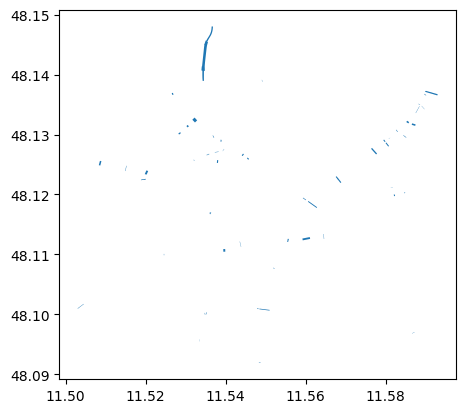

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file('munich_bridges.geojson')

gdf.plot()

In [8]:
gdf.total_bounds

array([11.5029771, 48.0919707, 11.5929976, 48.1480262])

In [9]:
import folium

In [10]:
gdf.iloc[0].geometry.bounds

(11.5352318, 48.1265183, 11.5359291, 48.1267952)

In [28]:
m = folium.Map(location=[gdf.iloc[0].geometry.bounds[1], gdf.iloc[0].geometry.bounds[0]], zoom_start=17, control_scale=True)

In [27]:
# Add the OSM data as a GeoJSON layer to the map
folium.GeoJson(gdf).add_to(m)

# Add a tile layer with satellite imagery
folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community').add_to(m)

# Show the map
m


In [25]:
m.zoom_level

AttributeError: 'Map' object has no attribute 'zoom_level'

# Downloading Image tiles and Masks
Since we've verified the OSM GT, I want to download tiles that I can use for finetuning the model. We'll need both image tiles and groundtruth masks.
For now, downloading only Munich is probably sufficient

In [20]:
# Getting extents of Munich in TMS
munich_bounds_tms = gdf.total_bounds

In [49]:
munich_bounds_tms

array([11.5029771, 48.0919707, 11.5929976, 48.1480262])

In [52]:
from samgeo import tms_to_geotiff
image = "munich_satellite_z16.tif"
tms_to_geotiff(output=image, bbox=list(munich_bounds_tms), zoom=16, source="Satellite", overwrite=True, crs="EPSG:4326")

Downloaded image 001/289
Downloaded image 002/289
Downloaded image 003/289
Downloaded image 004/289
Downloaded image 005/289
Downloaded image 006/289
Downloaded image 007/289
Downloaded image 008/289
Downloaded image 009/289
Downloaded image 010/289
Downloaded image 011/289
Downloaded image 012/289
Downloaded image 013/289
Downloaded image 014/289
Downloaded image 015/289
Downloaded image 016/289
Downloaded image 017/289
Downloaded image 018/289
Downloaded image 019/289
Downloaded image 020/289
Downloaded image 021/289
Downloaded image 022/289
Downloaded image 023/289
Downloaded image 024/289
Downloaded image 025/289
Downloaded image 026/289
Downloaded image 027/289
Downloaded image 028/289
Downloaded image 029/289
Downloaded image 030/289
Downloaded image 031/289
Downloaded image 032/289
Downloaded image 033/289
Downloaded image 034/289
Downloaded image 035/289
Downloaded image 036/289
Downloaded image 037/289
Downloaded image 038/289
Downloaded image 039/289
Downloaded image 040/289


In [53]:
list(munich_bounds_tms)

[11.5029771, 48.0919707, 11.5929976, 48.1480262]

In [61]:
# Create GeoTiff for Bridge Masks

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Open the existing GeoTIFF file
raster = rasterio.open(r"munich_satellite_z16.tif")

# Rasterize the geometries
geom = [shapes for shapes in gdf.geometry]

rasterized = rasterize(geom,
                    out_shape = raster.shape,
                    fill = 0,
                    out = None,
                    transform = raster.transform,
                    all_touched = False,
                    default_value = 1,
                    dtype = None)
with rasterio.open(
        "munich_bridge_masks_z16.tif", "w",
        driver = "GTiff",
        crs = raster.crs,
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)
